# Text-to-Animation Pipeline Performance Analysis

Comprehensive benchmark analysis following the same structure and quality as the main plotting notebook.

## Import Libraries

In [18]:
import os
import json
import glob
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# ------------------------------- setting start ------------------------------ #
# color
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
errorbar_color = "#3A3A3A"

# font
csfont = {'family':'Times New Roman', 'serif': 'Times' , 'size' : 23}
plt.rc('text', usetex=True)
plt.rc('font', **csfont)

label_fontsize = 24
lengends_fontsize = 20

# bar plot size
bar_width = 0.4
bar_btw_space = 0.04
bar_space = 0.2

# errorbar plot size
err_lw=1.5
err_capsize=4
err_capthick=1.5

# set fig size
figsize=(6.4, 4.8)
# -------------------------------- setting end ------------------------------- #

## Pipeline Performance Analysis Functions

Starting Text-to-Animation Pipeline Performance Analysis...
[INFO] Loaded 10 total runs (10 successful) from timing_data_2026-02-11_05-54-11.csv

Pipeline Stage Performance Statistics
Motion Generation   :   14.8s ±   0.1s (min:  14.0s, max:  15.0s, n: 10) [Stage1_Time_s]
Avatar Posing       :  119.9s ±   1.0s (min: 113.0s, max: 124.0s, n: 10) [Stage2_Time_s + Stage3_Time_s]
3DGS Rendering      :   83.7s ±   0.3s (min:  82.0s, max:  85.0s, n: 10) [Stage4_Time_s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



[INFO] Saved: pipeline_stage_performance.png and .eps in plots/pipeline_analysis


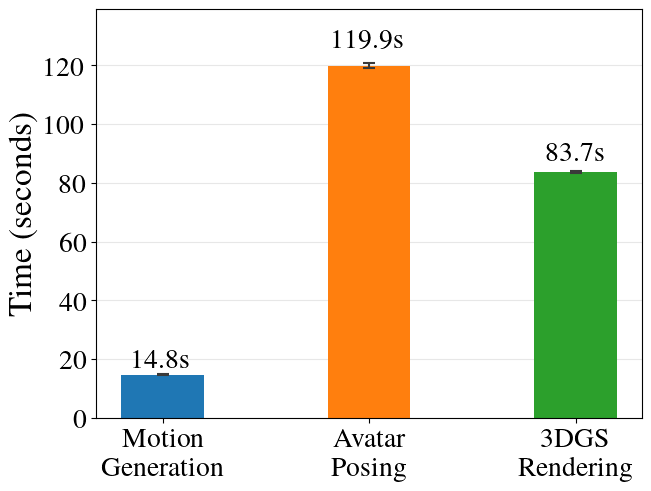

[INFO] Loaded 10 total runs (10 successful) from timing_data_2026-02-11_05-54-11.csv

Total Pipeline Time Analysis
Mean total time: 218.4s ± 3.2s
Range: 212.0s - 223.0s
Number of runs: 10


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



[INFO] Saved: pipeline_total_time_distribution.png and .eps in plots/pipeline_analysis


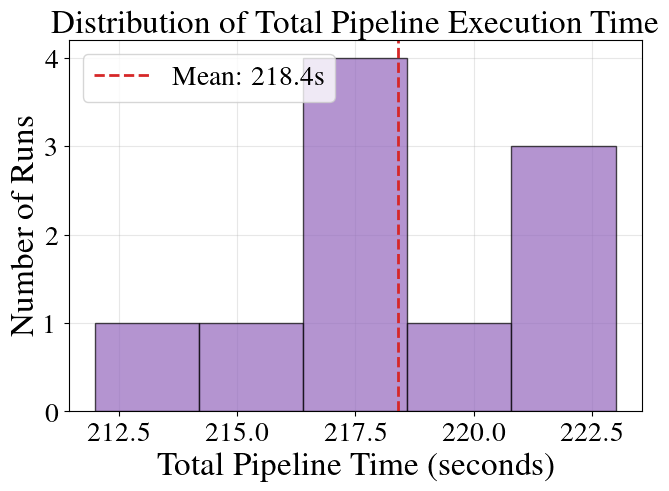


Analysis complete!


In [ ]:
def load_benchmark_data():
    """
    Load the latest benchmark timing data.
    
    Returns:
        pd.DataFrame: DataFrame containing successful runs data
        str: Path to the loaded file
    """
    benchmark_dir = Path('../benchmark')
    csv_files = list(benchmark_dir.glob('timing_data_*.csv'))
    
    if not csv_files:
        print("[ERROR] No benchmark data found. Run ./benchmark.sh first")
        return None, None
    
    # Get the latest file
    latest_file = max(csv_files, key=os.path.getmtime)
    
    try:
        df = pd.read_csv(latest_file)
        successful_runs = df[df['Status'] == 'SUCCESS']
        
        print(f"[INFO] Loaded {len(df)} total runs ({len(successful_runs)} successful) from {latest_file.name}")
        
        if len(successful_runs) == 0:
            print("[WARN] No successful runs found in the data")
            return None, str(latest_file)
            
        return successful_runs, str(latest_file)
        
    except Exception as e:
        print(f"[ERROR] Failed to load benchmark data: {e}")
        return None, None


def pipeline_stage_performance():
    """
    Create bar chart showing mean performance times for each pipeline stage.
    Includes error bars showing standard error across runs.
    """
    successful_runs, data_file = load_benchmark_data()
    
    if successful_runs is None:
        return
    
    output_dir = Path('./plots') / 'pipeline_analysis'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define stage information with proper labels (combining stages 2&3)
    stages_info = [
        {'keys': ['Stage1_Time_s'], 'label': 'Motion\nGeneration', 'color': color_palette[0]},
        {'keys': ['Stage2_Time_s', 'Stage3_Time_s'], 'label': 'Avatar\nPosing', 'color': color_palette[1]},
        {'keys': ['Stage4_Time_s'], 'label': '3DGS\nRendering', 'color': color_palette[2]}
    ]
    
    # Calculate statistics for each stage (combining as needed)
    stage_stats = []
    
    print(f"\n{'='*60}")
    print("Pipeline Stage Performance Statistics")
    print(f"{'='*60}")
    
    for stage_info in stages_info:
        stage_keys = stage_info['keys']
        stage_label = stage_info['label'].replace('\n', ' ')
        
        # Collect all timing data for this stage group
        all_stage_times = []
        available_keys = []
        
        for key in stage_keys:
            if key in successful_runs.columns:
                times = successful_runs[key].dropna()
                if len(times) > 0:
                    available_keys.append(key)
                    if len(all_stage_times) == 0:
                        all_stage_times = times.values
                    else:
                        # Add the times for combined stages
                        all_stage_times = all_stage_times + times.values
        
        if len(available_keys) > 0:
            mean_time = np.mean(all_stage_times)
            std_time = np.std(all_stage_times)
            stderr_time = std_time / np.sqrt(len(all_stage_times))
            min_time = np.min(all_stage_times)
            max_time = np.max(all_stage_times)
            
            stage_stats.append({
                'label': stage_info['label'],
                'mean': mean_time,
                'stderr': stderr_time,
                'color': stage_info['color']
            })
            
            combined_keys_str = ' + '.join(available_keys)
            print(f"{stage_label:20s}: {mean_time:6.1f}s ± {stderr_time:5.1f}s "
                  f"(min: {min_time:5.1f}s, max: {max_time:5.1f}s, n: {len(all_stage_times)}) [{combined_keys_str}]")
        else:
            print(f"{stage_label:20s}: No data available")
    
    if not stage_stats:
        print("[ERROR] No stage statistics available")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Extract data for plotting
    labels = [s['label'] for s in stage_stats]
    means = [s['mean'] for s in stage_stats]
    stderrs = [s['stderr'] for s in stage_stats]
    colors = [s['color'] for s in stage_stats]
    
    # Create bar chart with error bars
    x_pos = np.arange(len(labels))
    bars = ax.bar(x_pos, means, bar_width, yerr=stderrs, 
                  capsize=err_capsize, color=colors, 
                  error_kw={'elinewidth': err_lw, 'capthick': err_capthick, 'ecolor': errorbar_color})
    
    # Add value labels on top of bars
    for i, (bar, mean_val, stderr_val) in enumerate(zip(bars, means, stderrs)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + stderr_val + height*0.02,
                f'{mean_val:.1f}s', ha='center', va='bottom', fontsize=lengends_fontsize,
                fontweight='bold')
    
    # Formatting
    ax.set_ylabel('Time (seconds)', fontsize=label_fontsize)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=lengends_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=lengends_fontsize)
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set y-axis to start from 0 with some padding
    y_max = max(means) + max(stderrs)
    ax.set_ylim(0, y_max * 1.15)
    
    # Tight layout
    fig.set_constrained_layout(True)
    
    # Save plots
    base_name = 'pipeline_stage_performance'
    plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
    
    # Try to save EPS but handle LaTeX errors gracefully
    try:
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n[INFO] Saved: {base_name}.png and .eps in {output_dir}")
    except Exception as e:
        print(f"\n[INFO] Saved: {base_name}.png in {output_dir}")
        print(f"[WARN] EPS export failed due to LaTeX error (this is normal with percentage labels)")
    
    plt.show()
    plt.close()


def total_pipeline_time_analysis():
    """
    Analyze total pipeline time distribution and create histogram.
    """
    successful_runs, data_file = load_benchmark_data()
    
    if successful_runs is None:
        return
    
    output_dir = Path('./plots') / 'pipeline_analysis'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Calculate total time for each run
    stage_columns = ['Stage1_Time_s', 'Stage2_Time_s', 'Stage3_Time_s', 'Stage4_Time_s']
    available_columns = [col for col in stage_columns if col in successful_runs.columns]
    
    if not available_columns:
        print("[ERROR] No stage timing columns found")
        return
    
    successful_runs['Total_Time_s'] = successful_runs[available_columns].sum(axis=1)
    total_times = successful_runs['Total_Time_s'].dropna()
    
    if len(total_times) == 0:
        print("[ERROR] No total time data available")
        return
    
    # Statistics
    mean_total = np.mean(total_times)
    std_total = np.std(total_times)
    min_total = np.min(total_times)
    max_total = np.max(total_times)
    
    print(f"\n{'='*60}")
    print("Total Pipeline Time Analysis")
    print(f"{'='*60}")
    print(f"Mean total time: {mean_total:.1f}s ± {std_total:.1f}s")
    print(f"Range: {min_total:.1f}s - {max_total:.1f}s")
    print(f"Number of runs: {len(total_times)}")
    
    # Create histogram
    fig, ax = plt.subplots(figsize=figsize)
    
    n_bins = min(10, len(total_times) // 2) if len(total_times) > 2 else 5
    counts, bins, patches = ax.hist(total_times, bins=n_bins, color=color_palette[4], 
                                    alpha=0.7, edgecolor='black', linewidth=1)
    
    # Add vertical line for mean
    ax.axvline(mean_total, color=color_palette[3], linestyle='--', linewidth=2, 
               label=f'Mean: {mean_total:.1f}s')
    
    # Formatting
    ax.set_xlabel('Total Pipeline Time (seconds)', fontsize=label_fontsize)
    ax.set_ylabel('Number of Runs', fontsize=label_fontsize)
    ax.set_title(r'Distribution of Total Pipeline Execution Time', fontsize=label_fontsize)
    ax.legend(fontsize=lengends_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=lengends_fontsize)
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.3)
    
    
    # Try to save EPS but handle LaTeX errors gracefully
    try:
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n[INFO] Saved: {base_name}.png and .eps in {output_dir}")
    except Exception as e:
        print(f"\n[INFO] Saved: {base_name}.png in {output_dir}")
        print(f"[WARN] EPS export failed due to LaTeX error")
    
    plt.show()
    plt.close()


def run_all_analyses():
    """
    Execute all pipeline performance analyses.
    """
    print("Starting Text-to-Animation Pipeline Performance Analysis...")
    pipeline_stage_performance()
    total_pipeline_time_analysis()

    print("\nAnalysis complete!")
    print("\nAnalysis complete!")run_all_analyses()


run_all_analyses()


# Execute all analyses
# Execute all analyses

[INFO] Loaded 10 total runs (10 successful) from timing_data_2026-02-11_05-54-11.csv

Pipeline Breakdown vs Total Comparison
Motion Generation   :   14.8s ±   0.1s [Stage1_Time_s]
Avatar Posing       :  119.9s ±   1.0s [Stage2_Time_s + Stage3_Time_s]
3DGS Rendering      :   83.7s ±   0.3s [Stage4_Time_s]

Total Pipeline Time: 218.4s
Stage Percentages:
  Motion Generation   :   6.8%
  Avatar Posing       :  54.9%
  3DGS Rendering      :  38.3%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



[INFO] Saved: pipeline_breakdown_comparison.png and .eps in plots/pipeline_analysis


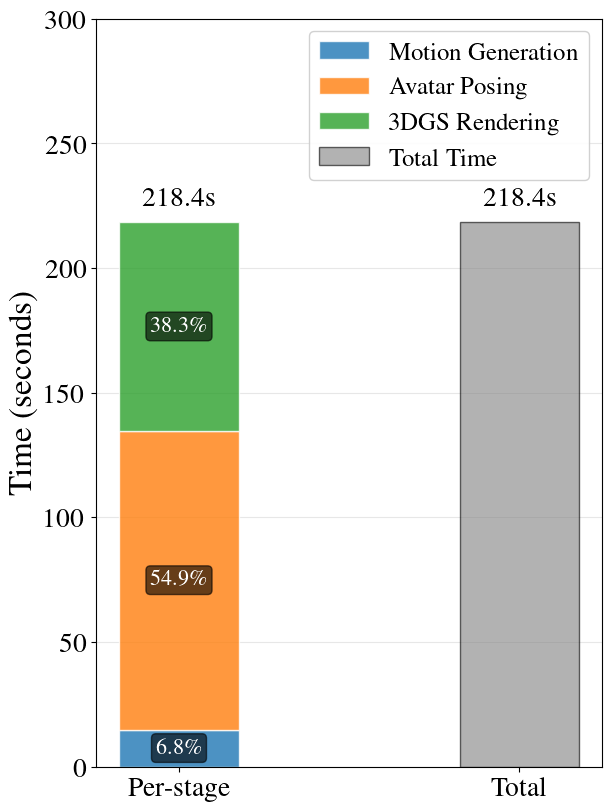

([{'label': 'Motion Generation',
   'mean': 14.8,
   'stderr': 0.12649110640673517,
   'color': '#1f77b4',
   'percentage': 6.7765567765567765},
  {'label': 'Avatar Posing',
   'mean': 119.9,
   'stderr': 0.9944847912361453,
   'color': '#ff7f0e',
   'percentage': 54.899267399267394},
  {'label': '3DGS Rendering',
   'mean': 83.7,
   'stderr': 0.34785054261852166,
   'color': '#2ca02c',
   'percentage': 38.324175824175825}],
 218.40000000000003)

In [51]:
def pipeline_breakdown_comparison():
    """
    Create side-by-side bar chart: left stacked (breakdown), right single (total).
    Shows pipeline stage breakdown vs total time comparison.
    """
    successful_runs, data_file = load_benchmark_data()
    
    if successful_runs is None:
        return
    
    output_dir = Path('./plots') / 'pipeline_analysis'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Define stage information (same as before)
    stages_info = [
        {'keys': ['Stage1_Time_s'], 'label': 'Motion Generation', 'color': color_palette[0]},
        {'keys': ['Stage2_Time_s', 'Stage3_Time_s'], 'label': 'Avatar Posing', 'color': color_palette[1]},
        {'keys': ['Stage4_Time_s'], 'label': '3DGS Rendering', 'color': color_palette[2]}
    ]
    
    # Calculate stage statistics
    stage_data = []
    total_time = 0
    
    print(f"\n{'='*60}")
    print("Pipeline Breakdown vs Total Comparison")
    print(f"{'='*60}")
    
    for stage_info in stages_info:
        stage_keys = stage_info['keys']
        stage_label = stage_info['label']
        
        # Calculate combined times per run for this stage group
        if len(stage_keys) == 1:
            # Single stage - just get the values directly
            key = stage_keys[0]
            if key in successful_runs.columns:
                times = successful_runs[key].dropna()
                if len(times) > 0:
                    combined_times = times.values
                else:
                    continue
            else:
                continue
        else:
            # Multiple stages - sum them per run, then get mean across runs
            combined_times = []
            for idx in successful_runs.index:
                run_total = 0
                valid_stages = 0
                for key in stage_keys:
                    if key in successful_runs.columns and not np.isnan(successful_runs.loc[idx, key]):
                        run_total += successful_runs.loc[idx, key]
                        valid_stages += 1
                
                # Only include this run if all required stages have data
                if valid_stages == len(stage_keys):
                    combined_times.append(run_total)
            
            combined_times = np.array(combined_times)
        
        if len(combined_times) > 0:
            mean_time = np.mean(combined_times)
            std_time = np.std(combined_times)
            stderr_time = std_time / np.sqrt(len(combined_times))
            
            stage_data.append({
                'label': stage_label,
                'mean': mean_time,
                'stderr': stderr_time,
                'color': stage_info['color']
            })
            
            total_time += mean_time
            stage_keys_str = ' + '.join(stage_keys)
            print(f"{stage_label:20s}: {mean_time:6.1f}s ± {stderr_time:5.1f}s [{stage_keys_str}]")
    
    if not stage_data:
        print("[ERROR] No stage data available")
        return
    
    # Calculate percentages
    for stage in stage_data:
        stage['percentage'] = (stage['mean'] / total_time) * 100 if total_time > 0 else 0
    
    print(f"\nTotal Pipeline Time: {total_time:.1f}s")
    print("Stage Percentages:")
    for stage in stage_data:
        print(f"  {stage['label']:20s}: {stage['percentage']:5.1f}%")
    
    # Create side-by-side bar chart
    fig, ax = plt.subplots(figsize=(6,8))
    
    bar_width_single = 0.35
    x_positions = [0, 1]  # Left: breakdown, Right: total
    x_labels = ['Per-stage', 'Total']
    
    # LEFT BAR: Stacked breakdown
    bottom = 0
    for i, stage in enumerate(stage_data):
        ax.bar(x_positions[0], stage['mean'], bar_width_single, 
               bottom=bottom, color=stage['color'], 
               label=stage['label'], alpha=0.8, edgecolor='white', linewidth=1)
        
        # Add percentage label in the middle of each segment
        segment_center = bottom + stage['mean'] / 2
        ax.text(x_positions[0], segment_center, f"{stage['percentage']:.1f}\\%", # latex escape for percentage
                ha='center', va='center', fontsize=lengends_fontsize-4, 
                fontweight='bold', color='white', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.6))
        
        bottom += stage['mean']
    
    # RIGHT BAR: Total (using a neutral color)
    ax.bar(x_positions[1], total_time, bar_width_single, 
           color='gray', alpha=0.6, edgecolor='black', linewidth=1, 
           label='Total Time')
    
    # Add value labels on bars
    ax.text(x_positions[0], total_time + total_time*0.02, f'{total_time:.1f}s', 
           ha='center', va='bottom', fontsize=lengends_fontsize, fontweight='bold')
    ax.text(x_positions[1], total_time + total_time*0.02, f'{total_time:.1f}s', 
           ha='center', va='bottom', fontsize=lengends_fontsize, fontweight='bold')
    
    # Formatting
    ax.set_ylabel('Time (seconds)', fontsize=label_fontsize)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=lengends_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=lengends_fontsize)
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set y-axis to start from 0 with some padding  
    ax.set_ylim(0, 300)
    
    # Add legend in top right corner
    ax.legend(loc='best', fontsize=lengends_fontsize-2, framealpha=0.9)
    
    # Tight layout
    fig.set_constrained_layout(True)
    
    # Save plots
    base_name = 'pipeline_breakdown_comparison'
    plt.savefig(output_dir / f'{base_name}.png', dpi=300, bbox_inches='tight')
    
    # Try to save EPS but handle LaTeX errors gracefully
    try:
        plt.savefig(output_dir / f'{base_name}.eps', format='eps', bbox_inches='tight')
        print(f"\n[INFO] Saved: {base_name}.png and .eps in {output_dir}")
    except Exception as e:
        print(f"\n[INFO] Saved: {base_name}.png in {output_dir}")
        print(f"[WARN] EPS export failed due to LaTeX error: {str(e).split('RuntimeError:')[-1].split('Here is the')[0].strip()}")
    
    plt.show()
    plt.close()
    
    return stage_data, total_time


# Run the new breakdown comparison plot
pipeline_breakdown_comparison()
